# Civic Analytics Using Open Data - Building Energy Data
### 2022 NYC Open Data Week

#### Author:  
**Bartosz Bonczak**  
Research Scientist and Lab Manager  
Civic Analytics Program @ NYU Marron Institute of Urban Management  
email: [bartosz.bonczak@nyu.edu](mailto:bartosz.bonczak@nyu.edu)

website: https://www.urbanintelligencelab.org  
GitHub: https://github.com/UrbanIntelligenceLab  
Social: [@UrbanIntelLab](https://twitter.com/urbanintellab)

#### Summary:
In this hands-on lab section we will breifly introduce Building Energy Benchmarking Data in NYC (aka "Energy and Water Data Disclosure for Local Law 84", LL84 data). 

#### About Local Law 84 Data
The NYC Benchmarking Law requires owners of large buildings greater than 25,000 ft$^2$ to annually measure their energy and water consumption in a process called benchmarking. The law standardizes this process by requiring building owners to enter their annual energy and water use in the U.S. Environmental Protection Agency's (EPA) online tool, ENERGY STAR Portfolio Manager® and use the tool to submit data to the City. Building Energy Benchmarking data is then published by the City administration on an annual basis. Up until now we have 11 years worth of data available on [NYC Open Data Platform](https://opendata.cityofnewyork.us). This data informs building owners about a building's energy and water consumption compared to similar buildings, and tracks progress year over year to help in energy efficiency planning.

In [1]:
# import required libraries
import pandas as pd
import numpy as np

from sodapy import Socrata

from urllib.request import urlopen
import json

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
%matplotlib inline

from pywaffle import Waffle

import seaborn as sns
sns.set_style('whitegrid')

import geopandas as gpd
from shapely.geometry import Point, LineString
import folium

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

# 1. Access most recent LL84 data with sodapy

Connect to the [Socrata API client (sodapy)](https://pypi.org/project/sodapy/0.1.4/) with an unauthenticated account and acess *["Energy and Water Data Disclosure for Local Law 84 2021 (Data for Calendar Year 2020)"](https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/usc3-8zwd)* dataset for further analysis.

In [2]:
# setup Socrata client, in this example we use generic, unauthenticated account
client = Socrata("data.cityofnewyork.us", None)
dataset_id = "usc3-8zwd"

# Obtain the dataset as JSON from API by sodapy.
data = client.get(dataset_id, limit=30000) # from data description we know the data has 28.1K rows
# data = client.get(dataset_id, limit=30000, select="property_id, nyc_borough_block_and_lot_bbl") # select specific columns only

# Convert results to pandas DataFrame
ll84_df = pd.DataFrame.from_records(data)

In [82]:
ll84_df = pd.DataFrame.from_records(data)

In [83]:
ll84_df.head()

,property_id,property_name,parent_property_id,parent_property_name,year_ending,nyc_borough_block_and_lot_bbl,nyc_building_identification_number_bin,address_1,city,postcode,...,number_of_active_it_meters,generation_date,release_date,borough,community_board,council_district,census_tract,nta,longitude,latitude
0,7365,1155,Not Applicable: Standalone Property,Not Applicable: Standalone Property,2020-12-31T00:00:00.000,1009970029,1022631,1155 Avenue of the Americas,Manhattan,10036,...,0,2021-05-20T14:43:12.000,2021-05-20T14:44:16.000,MANHATTAN,105,4,119,Midtown-Midtown South,-73.982826,40.756631
1,8139,200,Not Applicable: Standalone Property,Not Applicable: Standalone Property,2020-12-31T00:00:00.000,1013150001,1037545,200 East 42nd St.,Manhattan,10017,...,0,2021-05-20T14:43:12.000,2021-05-20T14:44:16.000,MANHATTAN,106,4,88,Turtle Bay-East Midtown,-73.974306,40.750698
2,8604,114,Not Applicable: Standalone Property,Not Applicable: Standalone Property,2020-12-31T00:00:00.000,1009990019,1022667,114 West 47th st,Manhattan,10036,...,0,2021-05-21T16:10:56.000,2021-05-21T16:13:00.000,MANHATTAN,105,4,125,Midtown-Midtown South,-73.982504,40.75831
3,8841,733,Not Applicable: Standalone Property,Not Applicable: Standalone Property,2020-12-31T00:00:00.000,1013190047,1037596,733 Third Avenue,Manhattan,10017,...,0,2021-05-20T14:43:13.000,2021-05-20T14:44:16.000,MANHATTAN,106,4,90,Turtle Bay-East Midtown,-73.972753,40.753074
4,11809,Conde Nast Building,Not Applicable: Standalone Property,Not Applicable: Standalone Property,2020-12-31T00:00:00.000,1009950005,1085682,4 Times Square,Manhattan,10036,...,0,2021-05-10T18:30:37.000,2021-05-10T18:34:54.000,MANHATTAN,105,4,119,Midtown-Midtown South,-73.986244,40.756181


In [84]:
# evaluate dataframe
print(f'# of rows: {len(ll84_df):,}')
print(f'# of colums: {ll84_df.shape[1]:,}')
print(f'memory usage: {round(ll84_df.memory_usage().sum()/(1024.0 * 1024.0), 2)} MB')

# of rows: 28,067
# of colums: 250
memory usage: 53.53 MB


# 2. Clean dataset

Because the data is of a self-reporting nature, it is prone to contain various types of errors and outliers. They can take form of simple typos, incorrect units, misunderstood values, miscalculations, misalignemnts, omissions, duplications etc. In order to ensure data quality, we need to undertake several steps of pre-processing and cleaning the data, depending on the analytical task.

Example cleaning steps proposed:
- Remove duplicated entries and keep the most recent report only;
- Replace 'Not Available' string value with NAN
- Convert numerical columns to numerical types
- Remove the outliers from selected columns, eg.: Energy Use Intensity

In [85]:
# Dictionary containing columns of interest groupped by the information type
columns_lists = {
    'identification':[
        'property_id','property_name',
        'nyc_borough_block_and_lot_bbl',
        'nyc_building_identification_number_bin',
        'address_1',
        'city',
        'postcode',
        'longitude',
        'latitude'
    ],
    'property_info':[
        'primary_property_type_self_selected',
        'year_built',
        'property_gfa_self_reported_ft',
        'number_of_buildings',
        'occupancy',
    ],
    'energy_performance':[
        'energy_star_score',
        'site_eui_kbtu_ft',
        'weather_normalized_site_eui_kbtu_ft',
        'site_energy_use_kbtu',
        'weather_normalized_site_energy_use_kbtu',
        'source_eui_kbtu_ft',
        'weather_normalized_source_eui_kbtu_ft',
        'source_energy_use_kbtu',
        'weather_normalized_source_energy_use_kbtu',
        'total_ghg_emissions_metric_tons_co2e',
        'total_ghg_emissions_intensity_kgco2e_ft',
    ],
    'fuel_mix':[
        'fuel_oil_1_use_kbtu',
        'fuel_oil_2_use_kbtu',
        'fuel_oil_4_use_kbtu',
        'fuel_oil_5_6_use_kbtu',
        'diesel_2_use_kbtu',
        'propane_use_kbtu',
        'district_steam_use_kbtu',
        'natural_gas_use_kbtu',
        'electricity_use_grid_purchase_kbtu',
        'electricity_use_generated_from_onsite_renewable_systems_and_used_onsite_kbtu',
    ],
    'water_consumption':[
        'indoor_water_use_all_water_sources_kgal',
        'outdoor_water_use_all_water_sources_kgal',
        'district_hot_water_use_kbtu',
        'district_chilled_water_use_kbtu',
    ]  
}

### Removing duplicates

In [86]:
# convert report generation date to datetime object
ll84_df['generation_date'] = pd.to_datetime(ll84_df['generation_date'])

# sort entries by generation date
ll84_df.sort_values(by='generation_date', ascending=True, inplace=True)

# remove entries with duplicated property ID information and keep only the most recent record
ll84_df.drop_duplicates(subset='property_id', keep='first', inplace=True)

# reset index after sorting
ll84_df.reset_index(drop=True, inplace=True)

### Clean Borough-Block-Lot (BBL) identifier

In [87]:
# clean BBL information
ll84_df['clean_bbl'] = ll84_df['nyc_borough_block_and_lot_bbl'] \
.apply(lambda x: str(x).replace('-', '')) \
.apply(lambda x: str(x).replace(' ', '')) \
.apply(lambda x: str(x).replace('/', '')) \
.apply(lambda x: x if len(x)==10 else x.split(';')[0])\
.apply(lambda x: x if len(x)==10 else x.split(',')[0])

ll84_df['clean_bbl'] = pd.to_numeric(ll84_df['clean_bbl'], errors='coerce')

### Replace textual 'Not Available' string value numerical NAN values

In [88]:
# Replace 'Not Available' string value with NAN
ll84_df = ll84_df.replace('Not Available', np.nan)

### Convert numbers to numerical values

In [89]:
# generate list of numerical columns
num_cols = columns_lists['property_info'] \
+ columns_lists['energy_performance'] \
+ columns_lists['fuel_mix'] \
+ columns_lists['water_consumption'] \
+ ['longitude', 'latitude']
    
num_cols.remove('primary_property_type_self_selected')

# convert series of objects to numerical
for c in num_cols:
    ll84_df[c] = pd.to_numeric(ll84_df[c], errors='coerce')

### Example of removing outliers in Source Energy Use Intensity (source EUI) column

EUI is one of the most important features in the dataset as it provides information about overal performance of the building. It is total energy consumed by building divided by it's gross floor area. There are several EUI columns:
- Site EUI: evaluates total energy consumed at the property level
- Source EUI: additionally incorporates energy required to produce and deliver energy to the property
- Weather Normalized Site/Source EUI: EUI adjusted by weather information in the form of Heating and Cooling Degree Days number

In [90]:
ll84_df['source_eui_kbtu_ft'].describe().round(2)

count     27049.00
mean        137.82
std        1122.01
min           0.00
25%          88.80
50%         114.30
75%         145.50
max      183038.40
Name: source_eui_kbtu_ft, dtype: float64

Text(0.5, 0, 'EUI [kbtu/ft$^2$]')

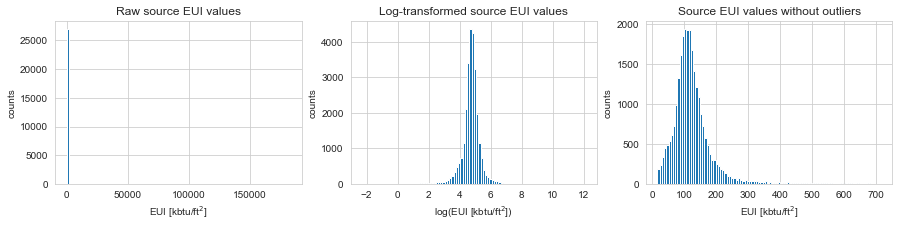

In [91]:
fig, ax = plt.subplots(1,3, figsize=(15,3))

# Plot the distribution of raw EUI values
ll84_df['source_eui_kbtu_ft'].hist(bins=100, ax=ax[0])
ax[0].set_title('Raw source EUI values')
ax[0].set_ylabel('counts')
ax[0].set_xlabel('EUI [kbtu/ft$^2$]')

# Log-transform source EUI values to obtain normal distribution
log_transformed = np.log(ll84_df['source_eui_kbtu_ft'])
log_transformed.replace([-np.inf, np.inf], np.nan).dropna().hist(bins=100, ax=ax[1])
ax[1].set_title('Log-transformed source EUI values')
ax[1].set_ylabel('counts')
ax[1].set_xlabel('log(EUI [kbtu/ft$^2$])')

# Calculate mean and std values
mean = np.mean(log_transformed.replace([-np.inf, np.inf], np.nan).dropna())
std = np.std(log_transformed.replace([-np.inf, np.inf], np.nan).dropna())

# Remove outliers +/- 3 std away from the mean of log-transformed source EUI values
ll84_df['source_eui_kbtu_ft'][(log_transformed<mean+(3*std)) & (log_transformed>mean-(3*std))].replace([-np.inf, np.inf], np.nan).dropna().hist(bins=100, ax=ax[2])
ax[2].set_title('Source EUI values without outliers')
ax[2].set_ylabel('counts')
ax[2].set_xlabel('EUI [kbtu/ft$^2$]')

In [92]:
# Remove outliers from the data frame
ll84_df = ll84_df[(log_transformed<mean+(3*std)) & (log_transformed>mean-(3*std))]

In [93]:
# evaluate dataframe after cleaning
print(f'# of rows: {len(ll84_df):,}')
print(f'# of colums: {ll84_df.shape[1]:,}')
print(f'memory usage: {round(ll84_df.memory_usage().sum()/(1024.0 * 1024.0), 2)} MB')

# of rows: 26,514
# of colums: 251
memory usage: 50.98 MB


# 3. Explore LL84 building stock

In [94]:
# create temporary dataframe with proprty information
temp = ll84_df[columns_lists['identification']+columns_lists['property_info']]

In [95]:
print(f'Number of property types: {temp["primary_property_type_self_selected"].nunique()}')
print()
print('Top 5 most common property type:')
temp["primary_property_type_self_selected"].value_counts().iloc[:5]

Number of property types: 74

Top 5 most common property type:


Multifamily Housing           18113
Office                         2206
K-12 School                    1568
Hotel                           527
Non-Refrigerated Warehouse      383
Name: primary_property_type_self_selected, dtype: int64

In [96]:
print(f'Total Gross Floor Area [sqft]: {temp["property_gfa_self_reported_ft"].sum()}')
print()
print('Top 5 most common property type:')
temp.groupby(["primary_property_type_self_selected"])["property_gfa_self_reported_ft"].sum().sort_values(ascending=False).round(2).iloc[:5].apply(lambda x: '%.2f' % x)

Total Gross Floor Area [sqft]: 3194470519.0

Top 5 most common property type:


primary_property_type_self_selected
Multifamily Housing    1873954676.00
Office                  530246247.00
K-12 School             181864806.00
Hotel                    77422564.00
College/University       66192064.00
Name: property_gfa_self_reported_ft, dtype: object

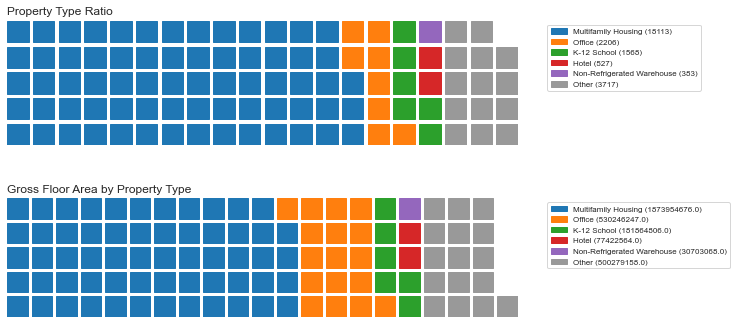

In [97]:
# Prepare data for plotting

# top 5 property types for number of buildings
plot_df_1 = pd.DataFrame(temp["primary_property_type_self_selected"].value_counts().iloc[:5])\
    .rename(columns={'primary_property_type_self_selected':'Number of properties'})
plot_df_1.index.name = 'Property type'

types_list = plot_df_1.index.tolist()

total_count = len(temp)
others_count = total_count - plot_df_1['Number of properties'].sum()

plot_df_1 = plot_df_1.append(pd.Series(index=['Number of properties'], data=[others_count], name='Other'))

# top 5 property types for gross floor area
plot_df_2 = pd.DataFrame(temp.groupby(["primary_property_type_self_selected"])["property_gfa_self_reported_ft"]\
                         .sum().sort_values(ascending=False).loc[types_list]).rename(columns={'property_gfa_self_reported_ft':'Gross Floor Area [sqrft]'})
plot_df_2.index.name = 'Property type'

total_gfa = temp["property_gfa_self_reported_ft"].sum()
others_gfa = total_gfa - plot_df_2['Gross Floor Area [sqrft]'].sum()

plot_df_2 = plot_df_2.append(pd.Series(index=['Gross Floor Area [sqrft]'], data=[others_gfa], name='Other'))

# combine the two data frames
plot_df = plot_df_1.join(plot_df_2)

# calculate ratios
plot_df['Number of properties ratio'] = plot_df['Number of properties'] / plot_df['Number of properties'].sum()
plot_df['Gross Floor Area [sqrft] ratio'] = plot_df['Gross Floor Area [sqrft]'] / plot_df['Gross Floor Area [sqrft]'].sum()

# Plot data as a waffle plot for comparison
fig = plt.figure(
    FigureClass=Waffle,
    plots={
        '211': {
            'values': plot_df['Number of properties ratio'] * 100,
            'labels': ["{0} ({1})".format(n, v) for n, v in plot_df['Number of properties'].items()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 8},
            'title': {'label': 'Property Type Ratio', 'loc': 'left'}
        },
        '212': {
            'values': plot_df['Gross Floor Area [sqrft] ratio'] * 100,
            'labels': ["{0} ({1})".format(n, v) for n, v in plot_df['Gross Floor Area [sqrft]'].items()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 8},
            'title': {'label': 'Gross Floor Area by Property Type', 'loc': 'left'}
        },
    },
    rows=5,
    colors=tuple([cm.tab10(i) for i in range(5)]+["#999999"]), # set colors
    figsize=(10, 5)  # specify figure size
)

# Build interactive map showing location and energy performance of LL84 properties

- Download MapPluto data from the [Bytes of the Big Apple](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page)
- Msubset=e with LL84 using Borough-Block-Lot (BBL) identifier
- Simplify geometries to speed up rendering 
- Use Folium plugin to create interactive map of LL84 properties

In [14]:
%%time
pluto = gpd.read_file('./nyc_mappluto_21v4_shp/MapPLUTO.shp') # this asumes MapPluto was downloaded inside the project folder
pluto.head()

CPU times: user 2min 27s, sys: 4min 30s, total: 6min 57s
Wall time: 13min 35s


,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,FIRM07_FLA,PFIRM15_FL,Version,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,geometry
0,MN,6,1,101,1000900,10009001014,9,1017,02,1,...,1,1,21v4,t,40.702609,-74.009900,None,0.0,36256.592536,"POLYGON ((981398.159 195460.869, 981413.330 19..."
1,MN,2,1,101,1000900,10009001022,9,1025,02,1,...,1,1,21v4,t,40.700369,-74.012911,None,0.0,100824.967451,"POLYGON ((980639.785 194217.691, 980609.551 19..."
2,MN,2,23,101,1000900,10009001022,9,1025,02,1,...,1,1,21v4,t,40.701171,-74.009243,None,0.0,96902.368779,"MULTIPOLYGON (((981182.221 194851.167, 981181...."
3,MN,3,1,101,1001300,10013002002,13,2005,02,1,...,1,1,21v4,None,40.702806,-74.015631,None,0.0,921410.335268,"MULTIPOLYGON (((980152.176 194762.899, 980089...."
4,MN,3,4,101,1031900,None,319,None,02,1,...,1,1,21v4,None,40.701255,-74.013939,None,0.0,2777.210233,"POLYGON ((980403.205 194731.754, 980401.324 19..."


In [98]:
# Merge LL84 data with PLUTO
ll84_df_gdf = pd.merge(ll84_df, pluto[['BBL', 'geometry']], how='left', left_on='clean_bbl', right_on='BBL')
ll84_df_gdf = gpd.GeoDataFrame(data=ll84_df_gdf, geometry=ll84_df_gdf['geometry'], crs=pluto.crs)
ll84_df_gdf.dropna(subset=['geometry'], inplace=True)
ll84_df_gdf.geometry = ll84_df_gdf.geometry.simplify(0.01)

In [ ]:
# define data to be used in the map
map_df = ll84_df_gdf[["source_eui_kbtu_ft", "nyc_borough_block_and_lot_bbl", 
                 "primary_property_type_self_selected", "year_built", "property_gfa_self_reported_ft",
                 "energy_star_score", "geometry"]].dropna()

# define map object
m = map_df.explore(
     width='75%', height='100%',
     column="source_eui_kbtu_ft", # specify column for choropleth
     tooltip=["nyc_borough_block_and_lot_bbl", "primary_property_type_self_selected", 
              "year_built", "property_gfa_self_reported_ft", 
              "source_eui_kbtu_ft", "energy_star_score"], # define tooltip
     popup=True, # enable popup
     tiles="CartoDB positron", # specify basemap style
     cmap="coolwarm", # specify colormap
     scheme="NaturalBreaks", # define scale
     style_kwds=dict(stroke=False) # style objects
    )

m.save("../image/ll84_eui_choropleth.html")
m # show folium object

# References:

- [SodaPy documentation](https://github.com/xmunoz/sodapy)
- [Energy and Water Data Disclosure for Local Law 84 2021 (Data for Calendar Year 2020) record on NYC Open Data platform](https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/usc3-8zwd)
- More on Local Law 84 and other NYC Green Initiatives can be found [here](https://www1.nyc.gov/site/sustainability/legislation/greener-greater-buildings-plan-2009.page) and [here](https://www1.nyc.gov/html/gbee/html/plan/training_ll84.shtml)
- [SODA API documentation for LL84 data on SODA Developers portal](https://dev.socrata.com/foundry/data.cityofnewyork.us/usc3-8zwd)
- [PyWaffle documentation](https://github.com/gyli/PyWaffle)